In [1]:
import pandas as pd
from matplotlib.pylab import plt
import numpy as np
%matplotlib inline
from sklearn.externals import joblib

In [2]:
df = pd.read_pickle('cleaned_data.p')

In [3]:
df.shape

(90811, 70)

In [4]:
df.columns

Index([u'numberofstories', u'logerror', u'poolcnt', u'reserves', u'yearbuilt',
       u'roomcnt', u'bedroomcnt', u'taxamount', u'schiller', u'assessmentyear',
       u'parcelid', u'bathroomcnt', u'garagecarcnt', u'fullbathcnt',
       u'transactiondate', u'finishedsquarefeet12', u'lotsizesquarefeet',
       u'airconditioningtypeid_1.0', u'airconditioningtypeid_3.0',
       u'airconditioningtypeid_5.0', u'airconditioningtypeid_9.0',
       u'airconditioningtypeid_11.0', u'airconditioningtypeid_13.0',
       u'buildingqualitytypeid_1.0', u'buildingqualitytypeid_4.0',
       u'buildingqualitytypeid_6.0', u'buildingqualitytypeid_7.0',
       u'buildingqualitytypeid_8.0', u'buildingqualitytypeid_10.0',
       u'buildingqualitytypeid_11.0', u'buildingqualitytypeid_12.0',
       u'heatingorsystemtypeid_1.0', u'heatingorsystemtypeid_2.0',
       u'heatingorsystemtypeid_6.0', u'heatingorsystemtypeid_7.0',
       u'heatingorsystemtypeid_10.0', u'heatingorsystemtypeid_11.0',
       u'heatingorsys

In [5]:
df_model = df.set_index(['transactiondate', 'parcelid']).sort_index()

In [6]:
df_model.dtypes.unique()

array([dtype('float64'), dtype('uint8'), dtype('int64')], dtype=object)

make X and y and scale X to between 0 and 1 inclusive

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [12]:
y = df_model.logerror.values
df_X = df_model.drop('logerror', axis=1)
X = scaler.fit_transform(df_X)
df_X.to_pickle('df_X.p')

In [11]:
np.save('y', y)
np.save('X', X)

split into train test for baseline model

In [9]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=2)

In [10]:
train_idx, test_idx = tss.split(X).next()

In [11]:
X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]

In [12]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(criterion='mse', max_depth=20)

In [13]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [14]:
joblib.dump(rfr, 'baseline_rfr_model.pkl')

['baseline_rfr_model.pkl']

In [15]:
predictions = rfr.predict(X_test)

In [16]:
from sklearn.metrics import mean_absolute_error
baseline_error_train = mean_absolute_error(y_train, rfr.predict(X_train))
baseline_error_test = mean_absolute_error(y_test, predictions)

In [17]:
print baseline_error_train
print baseline_error_test

0.0638212503731
0.105014553838


In [18]:
mean_absolute_error(y_test, np.repeat(0.0, len(y_test)))

0.066929643211100107

In [3]:
rfr = joblib.load('baseline_rfr_model.pkl')

In [18]:
importances = pd.DataFrame(zip(df_model.drop('logerror', axis=1).columns,
                               rfr.feature_importances_), columns=['feature', 'importance'])

In [25]:
top20 = importances.sort_values('importance', ascending=False).set_index('feature')[:20]

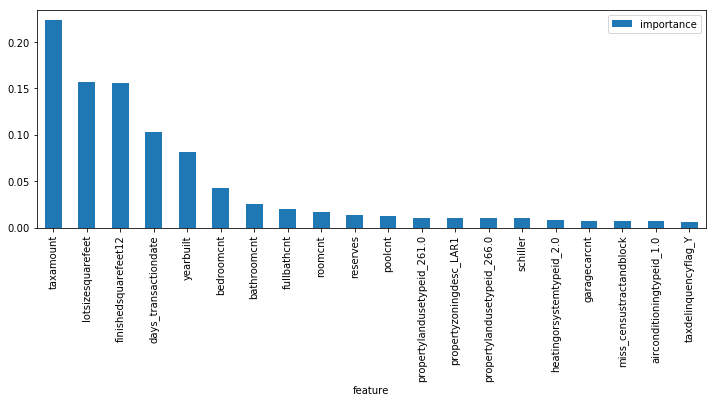

In [28]:
top20.plot(kind='bar', figsize=(12, 4))